## Винеровский фильтр



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from mel_spectrogram.mel_spectrogram import (
    load_audio,
    split_track_into_frames,
    apply_hann_window,
    compute_stft,
    compute_mel_spectrogram,
    synthesize_signal,
    show_mel,
)

In [2]:
# Определяем функцию для добавления белого шума
def add_noise(signal, noise_level=0.02, seed=0):
    signal = np.asarray(signal, dtype=np.float64)
    rng = np.random.default_rng(seed)
    noise = rng.normal(scale=noise_level, size=signal.shape)
    noisy = signal + noise
    max_abs = np.max(np.abs(noisy)) + 1e-12
    return noisy / max_abs


In [3]:
# Настраиваем пути и гиперпараметры винеровской фильтрации
audio_path = 'audio/birds.mp3'       # путь к исходному файлу
window_samples = 1024                # длина окна N
hop_samples = window_samples // 4    # шаг H
noise_duration = 0.4                 # длительность шумового отрезка, с
eps = 1e-8                           # защита от деления на ноль
noise_level = 0.02                   # амплитуда добавляемого белого шума

In [4]:
# Загружаем аудио, нормализуем, добавляем шум и считаем STFT
clean_audio, sample_rate = load_audio(audio_path, mono=True)
max_val = np.max(np.abs(clean_audio)) + 1e-12
clean_audio = clean_audio / max_val

noisy_audio = add_noise(clean_audio, noise_level=noise_level)

frames, n_frames = split_track_into_frames(noisy_audio, window_samples, hop_samples)
window, windowed_frames = apply_hann_window(frames, window_samples)
n_fft = 2 ** (int(np.log2(window_samples)) + 1)

stft, freqs, amplitude, power = compute_stft(windowed_frames, n_fft, sample_rate)
magnitude_sq = np.abs(stft) ** 2

print(f'Фреймов: {stft.shape[0]}, частотных бинов: {stft.shape[1]}')
print(f'Дискретизация: {sample_rate} Гц')

Фреймов: 4340, частотных бинов: 1025
Дискретизация: 44100 Гц


In [ ]:
# Оцениваем шум и применяем винеровский фильтр
# Формула: SNR(m,k) = max(|X(m,k)|^2 - P_N(k), 0) / (P_N(k) + eps), G = SNR / (1 + SNR)
hop_duration = hop_samples / sample_rate
noise_frames = max(1, int(np.ceil(noise_duration / hop_duration)))
noise_frames = min(noise_frames, stft.shape[0])

noise_power = magnitude_sq[:noise_frames].mean(axis=0)
a_posteriori_snr = np.maximum(magnitude_sq - noise_power[None, :], 0.0) / (noise_power[None, :] + eps)
gain = a_posteriori_snr / (1.0 + a_posteriori_snr)
enhanced_stft = gain * stft

print(f'Шум оценивается по {noise_frames} окнам (~{noise_frames * hop_duration:.2f} с)')

Шум оценивается по 69 окнам (~0.40 с)


In [6]:
# Выполняем обратное преобразование и сохраняем очищённый сигнал
output_base, sep, suffix = audio_path.rpartition('.')
noisy_output_path = f"{output_base}_noisy.wav"
denoised_output_path = f"{output_base}_denoised_wiener.wav"

enhanced_audio = synthesize_signal(enhanced_stft, window, hop_samples, clean_audio.shape[0], n_fft)
sf.write(noisy_output_path, noisy_audio, sample_rate)
sf.write(denoised_output_path, enhanced_audio, sample_rate)
print(f'Зашумленный файл сохранён: {noisy_output_path}')
print(f'Очищенный файл сохранён: {denoised_output_path}')


Зашумленный файл сохранён: audio/birds_noisy.wav
Очищенный файл сохранён: audio/birds_denoised_wiener.wav


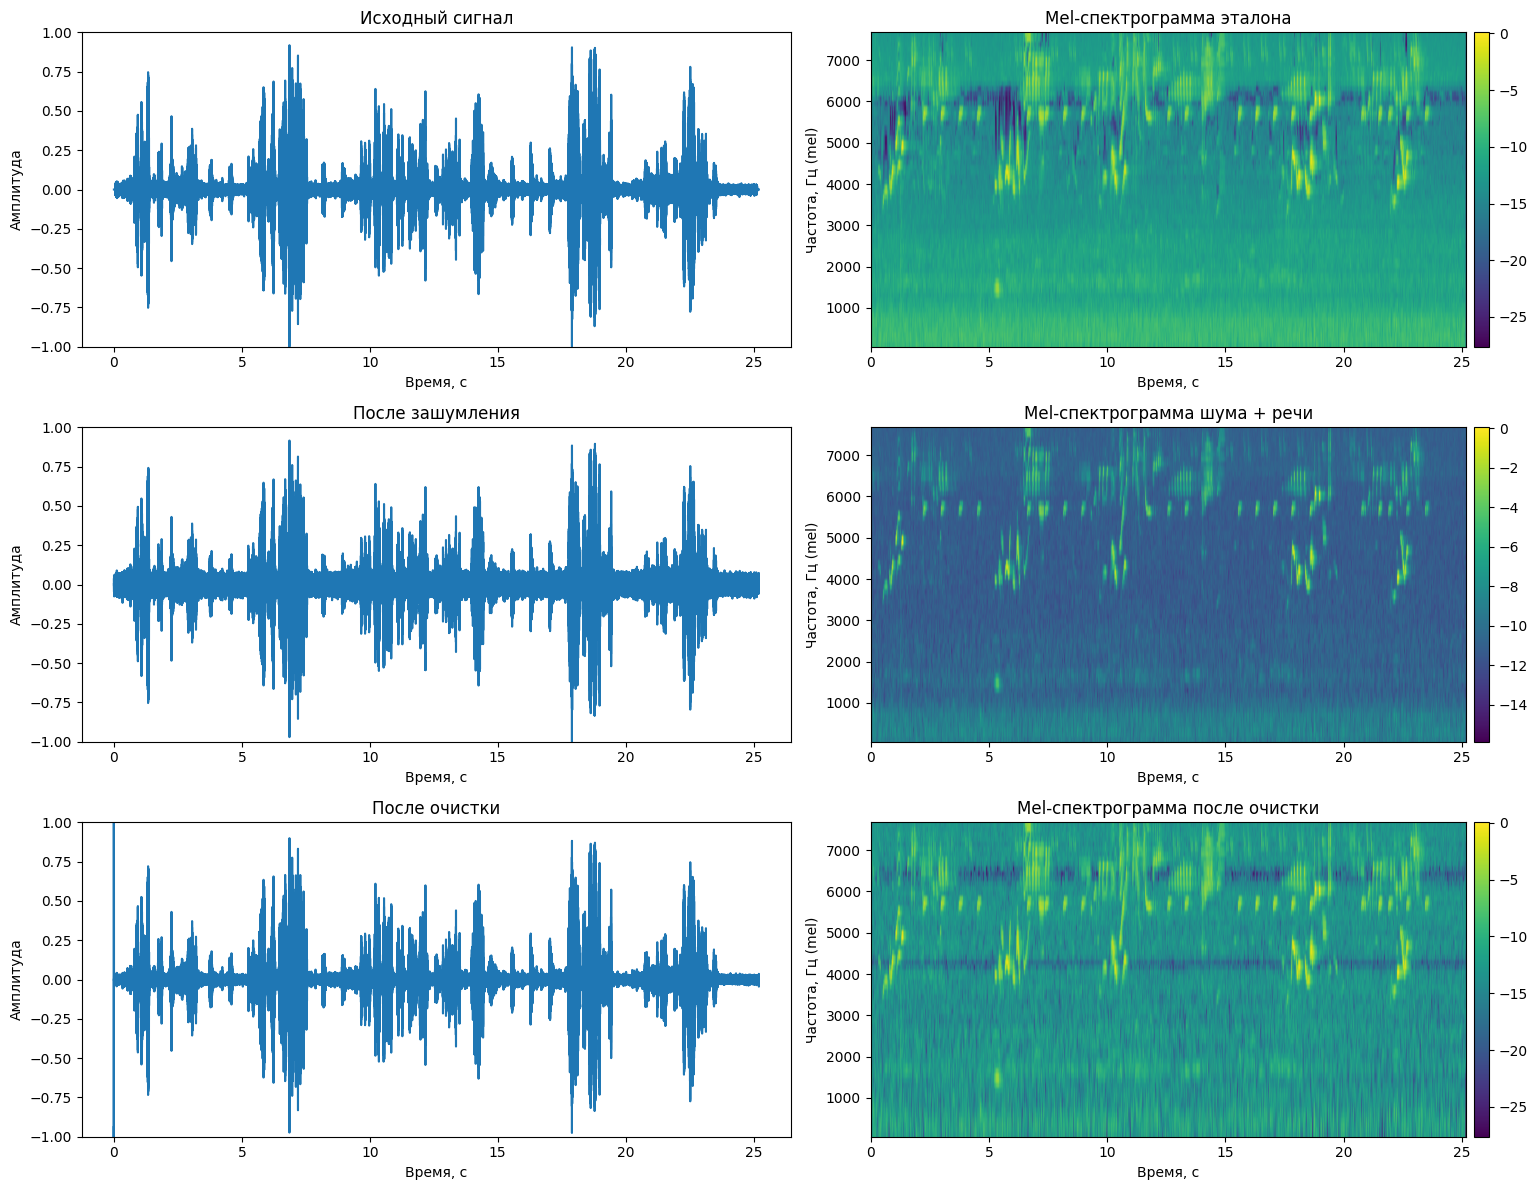

In [7]:
# Строим графики и mel-спектрограммы для сравнения до/после
mel_params = dict(window_ms=25.0, hop_ms=10.0, n_mels=64, f_min=30.0, f_max=8000.0, log_scale=True)
mel_clean = compute_mel_spectrogram(clean_audio, sample_rate, **mel_params)
mel_noisy = compute_mel_spectrogram(noisy_audio, sample_rate, **mel_params)
mel_denoised = compute_mel_spectrogram(enhanced_audio, sample_rate, **mel_params)

time_axis = np.arange(clean_audio.size) / sample_rate
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [
    (clean_audio, 'Исходный сигнал', mel_clean, 'Mel-спектрограмма эталона'),
    (noisy_audio, 'После зашумления', mel_noisy, 'Mel-спектрограмма шума + речи'),
    (enhanced_audio, 'После очистки', mel_denoised, 'Mel-спектрограмма после очистки'),
]

for row, (signal, wave_title, mel_result, mel_title) in enumerate(comparisons):
    ax_wave = axes[row, 0]
    ax_wave.plot(time_axis, signal)
    ax_wave.set_title(wave_title)
    ax_wave.set_xlabel('Время, с')
    ax_wave.set_ylabel('Амплитуда')
    ax_wave.set_ylim((-1, 1))

    ax_mel = axes[row, 1]
    show_mel(ax_mel, mel_result, mel_title)

fig.tight_layout()


In [8]:
# Считаем численные метрики качества очистки (SI-SDR и SNR)
def si_sdr(reference, estimate, eps=1e-8):
    reference = reference - reference.mean()
    estimate = estimate - estimate.mean()
    scale = np.dot(estimate, reference) / (np.dot(reference, reference) + eps)
    target = scale * reference
    noise = estimate - target
    return 10 * np.log10((np.sum(target ** 2) + eps) / (np.sum(noise ** 2) + eps))

def snr(reference, estimate, eps=1e-8):
    noise = reference - estimate
    return 10 * np.log10((np.sum(reference ** 2) + eps) / (np.sum(noise ** 2) + eps))

metrics = {
    'SI-SDR (noisy)': si_sdr(clean_audio, noisy_audio),
    'SI-SDR (denoised)': si_sdr(clean_audio, enhanced_audio),
    'SNR (noisy)': snr(clean_audio, noisy_audio),
    'SNR (denoised)': snr(clean_audio, enhanced_audio),
}

for name, value in metrics.items():
    print(f"{name}: {value:.2f} дБ")


SI-SDR (noisy): 13.19 дБ
SI-SDR (denoised): 14.62 дБ
SNR (noisy): 13.37 дБ
SNR (denoised): 14.75 дБ
